# Q4.a - Employee Task Automation
This Jupyter Notebook provides to the user two modes:

1) City Reporter
   - Loads a saved Naive Bayes model + vectorizer
   - Predicts a category for each news article in Daily_News.csv
   - Asks the user to choose a city and category
   - Uses Uniform Cost Search (UCS) to find the shortest path from the city office to each matching news location
   - Outputs results as a DataFrame (Summary, Location, Path, Cost)

2) Executive Correspondent
   - Asks the user to select at least 2 cities to visit
   - Uses a Genetic Algorithm to find an optimised round trip starting/ending in Phoenix
   - Prints the best route and total distance (based on the DISTANCES assumptions)

Project folders used:
- src/       : city graphs (citymap_data.py)
- models/    : saved model and vectorizer (.pkl)
- data/      : Daily_News.csv

In [ ]:
import pandas as pd
import pickle
import heapq
import random
import sys
from pathlib import Path

# Adds the project root to the Python path so we can import citymap_data.py from src folder correctly
# This allows the program to run either from the project root folder or from /notebooks
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Paths to the trained model, vectorizer, and the daily news dataset used by City Reporter mode
MODEL_PATH = ROOT / "models" / "best_nb_model.pkl"
VECT_PATH  = ROOT / "models" / "best_nb_vectorizer.pkl"
DATA_PATH  = ROOT / "data" / "Daily_News.csv"

from src.citymap_data import (
    Phoenix_cities,
    Los_Angeles_cities,
    Las_Vegas_cities,
    San_Diego_cities,
)

# Graphs: each city maps to an adjacency dictionary with costs between locations
CITY_GRAPHS = {
    "Phoenix": Phoenix_cities,
    "Los Angeles": Los_Angeles_cities,
    "Las Vegas": Las_Vegas_cities,
    "San Diego": San_Diego_cities
}

# User input is converted to uppercase so city matching is not case sensitive
valid_reporter_cities = {
    "PHOENIX": "Phoenix",
    "LOS ANGELES": "Los Angeles",
    "LAS VEGAS": "Las Vegas",
    "SAN DIEGO": "San Diego"
}

valid_executive_cities = {
    "LOS ANGELES": "Los Angeles",
    "LAS VEGAS": "Las Vegas",
    "SAN DIEGO": "San Diego"
}

In [300]:
def uniform_cost_search(graph, start, goal):
    """
    Uniform Cost Search (UCS) algorithm.
    This algorithm explores the graph choosing always the lowest-cost path first.

    Returns:
        path (list): shortest path found from start node to goal node
        cost (float): the total cost of the path
    
    Note: code reused from 03_path_finder.ipynb and adapted
    """
    pq = [(0, start)]
    parent = {start: None}
    cost_so_far = {start: 0}

    while pq:
        cost, node = heapq.heappop(pq)

        if node == goal:
            path = []
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return path, cost

        for neighbor, edge_cost in graph[node].items():
            new_cost = cost + edge_cost
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                parent[neighbor] = node
                heapq.heappush(pq, (new_cost, neighbor))

    return None, float("inf")

In [ ]:
# Distances are in miles taken from CA assignment, and are used
# only for the executive route optimisation in the Genetic Algorithm
DISTANCES = {
    ("Phoenix", "Los Angeles"): 370,
    ("Phoenix", "San Diego"): 355,
    ("Phoenix", "Las Vegas"): 300,
    ("Los Angeles", "San Diego"): 120,
    ("Los Angeles", "Las Vegas"): 270,
    ("San Diego", "Las Vegas"): 330
}

def distance(a, b):
    """
    Returns the distance between two cities using the above DISTANCES table.
    (A, B) and (B, A) are treated as symmetric so the distance can be found in any order.
    If the distance is not defined, it raises an error.
    """
    if a == b:
        return 0
    
    d = DISTANCES.get((a, b)) or DISTANCES.get((b, a))

    if d is None:
        raise ValueError(f"Missing distance between {a} and {b}")
    
    return d

In [302]:
def route_cost(route):
    """
    Helper function to calculate the total distance of a route
    by adding the distance between each pair of cities in the route.
    """
    total = 0
    for i in range(len(route) - 1):
        total += distance(route[i], route[i + 1])
    return total

In [303]:
def random_selection(population):
    """
    Selects one route from the population using weighted random selection
    """
    weights = []

    for ind in population:
        full_route = ["Phoenix"] + ind + ["Phoenix"]
        weights.append(1 / (route_cost(full_route) + 1e-9))
        # +1e-9 avoids division by zero to prevent this possibility
        
    return random.choices(population, weights=weights, k=1)[0]

def reproduce(p1, p2):
    """
    Creates a child route from the two given parent routes.

    The first part of the route is taken from parent 1, and the rest of the cities
    are taken from parent 2, keeping the same order and avoiding duplications.
    """
    cut = random.randint(1, len(p1) - 1)

    # Take the first part from parent 1
    child = p1[:cut]

    # Add remaining cities from parent 2, keeping same order and avoiding duplicates
    for city in p2:
        if city not in child:
            child.append(city)

    return child


def mutate(route):
    """
    Applies a small random change to a route based on mutation_rate (same as from the labs).
    """
    mutation_rate = 0.1
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return route


In [304]:
def genetic_algorithm(cities, population_size=10, generations=50):
    """
    Genetic Algorithm that finds an approximate best travel route.

    The route, as defined in the CA, always starts and end in Phoenix, and visits
    all selected cities once.

    Returns:
        best_route (list): the route, including Phoenix as start and end point
        best_cost (float): total cost of the route
    """
    # Build initial population (random routes)
    population = []
    for _ in range(population_size):
        individual_route = random.sample(cities, len(cities))
        population.append(individual_route)

    # Evolve population over the number of generations
    for _ in range(generations):
        new_population = []

        for _ in range(population_size):
            parent1 = random_selection(population)
            parent2 = random_selection(population)

            child = reproduce(parent1, parent2)
            child = mutate(child)

            new_population.append(child)

        population = new_population

    # Pick the best route from the final population
    best = None
    best_cost = float("inf")

    for route in population:
        # Phoenix is treated as the fixed start/end point for the executive route
        full_route = ["Phoenix"] + route + ["Phoenix"]
        cost = route_cost(full_route)

        if cost < best_cost:
            best_cost = cost
            best = route

    best_route = ["Phoenix"] + best + ["Phoenix"]
    return best_route, best_cost

In [305]:
def get_employee_type():
    """ 
    Basic menu where the user has to select the type of employee.
    If an invalid option has been chosen, then the loop repeats.
    """
    while True:
        print("Employee Task Automation Menu")
        print("1) Executive Correspondent")
        print("2) City Reporter")

        employee_type = input("Select employee type (1 or 2): ").strip()

        if employee_type in ["1", "2"]:
            return employee_type
        else:
            print("Invalid input. Please enter 1 or 2.\n")

In [306]:
def get_reporter_city(valid_reporter_cities):
    """ 
    Asks the reporter to input a city from the options given.
    If the input is not correct, it will ask again. Input is not
    case sensitive, as the comparison is done un uppercase.
    """
    while True:
        user_input = input(
            "Enter your city (Phoenix / Los Angeles / Las Vegas / San Diego): "
        ).strip().upper()

        if user_input in valid_reporter_cities:
            return valid_reporter_cities[user_input]
        else:
            print("Invalid city. Please try again.\n")

In [307]:
def get_reporter_category(valid_categories):
    """ 
    Asks the reporter to select one of the available categories.
    Instead of asking the user to type the entire category name, 
    it displays a menu with numbers for each category, so choosing
    one of them is much easier for the user.

    Returns:
        reporter_category (str): the chosen category
    """
    # Display numbered menu
    print("\nSelect a news category:")
    for i, category in enumerate(valid_categories, start=1):
        print(f"{i}) {category}")

    # Ask user to choose by number
    while True:
        choice = input("Enter category number: ").strip()

        if choice.isdigit():
            choice = int(choice)
            if 1 <= choice <= len(valid_categories):
                return valid_categories[choice - 1]

        print("Invalid selection. Please enter a valid number.\n")

In [308]:
def run_city_reporter(valid_reporter_cities):
    """
    City Reporter mode:
    - Loads the saved Naive Bayes model and vectorizer
    - Predicts a category for each news article
    - Asks the user for a city and category
    - Uses UCS to find shortest paths to matching news locations
    
    Returns:
        results_df (DataFrame): a DataFrame with the results (summary, location, path, cost)
    """
    print("City Reporter mode selected")
    # Loads preivously saved models and Daily_News.csv
    with open(MODEL_PATH, "rb") as f:
        model = pickle.load(f)

    with open(VECT_PATH, "rb") as f:
        vectorizer = pickle.load(f)

    news_df = pd.read_csv(DATA_PATH)

    # Combines Summary and Text to use in the prediction
    clean_summary = news_df["Summary"].fillna("").astype(str)
    clean_text = news_df["Text"].fillna("").astype(str)
    news_df["combined_text"] = (clean_summary + " " + clean_text).str.strip()

    # Categories prediction and conversion to uppercase
    X = vectorizer.transform(news_df["combined_text"])
    news_df["PredictedCategory"] = model.predict(X)
    news_df["PredictedCategory"] = news_df["PredictedCategory"].astype(str).str.upper()

    # Input from the user for city, forcing to choose a valid one
    # Not case sensitive
    reporter_city = get_reporter_city(valid_reporter_cities)

    # Input from the user for category, forcing him to choose a valid one
    # The comparation is based on the categories that are present in the model
    # Not case sensitive
    valid_categories = list(news_df["PredictedCategory"].dropna().unique())
    valid_categories.sort()

    reporter_category = get_reporter_category(valid_categories)

    office = reporter_city
    graph = CITY_GRAPHS[reporter_city]

    # Filters matching articles and shows results
    matches = news_df[
        (news_df["PredictedCategory"] == reporter_category) &
        (news_df["Location"].isin(graph.keys()))
    ]

    if matches.empty:
        print("No matching news articles found.")
        return

    # Returns the path and it's cost in table format
    # Build a results table (DataFrame) so the output is easier to read
    rows = []

    locations = matches["Location"].tolist()
    summaries = matches["Summary"].tolist()

    for i in range(len(locations)):
        destination = locations[i]
        summary = summaries[i]

        path, cost = uniform_cost_search(graph, office, destination)
        if path:
            path_str = " -> ".join(path)
        else:
            path_str = "No path found"
        
        rows.append({
            "Summary": summary,
            "Location": destination,
            "Path": path_str,
            "Cost (graph units)": cost
        })

    results_df = pd.DataFrame(rows)
    results_df.index = range(1, len(results_df) + 1)

    print("\nShortest paths to matching news locations:")
    return results_df

In [309]:
def parse_executive_cities(cities_input, valid_executive_cities):
    """
    Parses and validates the Executive Correspondent city input.

    - Accepts city names separated by a comma
    - Converts them to uppercase to make it not case sensitive
    - Rejects invalid cities
    - Removes duplicates while keeping the original order
    
    Returns:
        (cities_to_visit, error_message):
            cities_to_visit (list or None): parsed list of cities if valid
            error_message (str or None): error message if invalid
    """
    parts = cities_input.split(",")
    cities_raw = []
    for part in parts:
        cleaned = part.strip()
        if cleaned != "":
            cities_raw.append(cleaned.upper())

    if len(cities_raw) < 2:
        return None, "Please enter at least TWO cities.\n"

    # Validate cities
    for city in cities_raw:
        if city not in valid_executive_cities:
            return None, "Invalid city entered. Please choose from: Los Angeles, Las Vegas, San Diego.\n"

    cities_to_visit = []
    for city in cities_raw:
        proper_name = valid_executive_cities[city]
        if proper_name not in cities_to_visit:
            cities_to_visit.append(proper_name)

    if len(cities_to_visit) < 2:
        return None, "Please enter at least TWO DIFFERENT cities (e.g., Los Angeles, San Diego).\n"

    return cities_to_visit, None


In [ ]:
def run_executive_correspondent(valid_executive_cities):
    """
    Executive Correspondent mode:
    - Asks the user for two cities or more to visit
    - Validates the input using parse_executive_cities()
    - Runs the genetic algorithm to find an optimised round trip starting/ending in Phoenix
    - Prints the chosen route and total distance
    """
    print("Executive Correspondent mode selected")
    while True:
        cities_input = input(
            "Enter cities to visit (Los Angeles, Las Vegas, San Diego) separated by commas: "
        ).strip()

        cities_to_visit, error = parse_executive_cities(cities_input, valid_executive_cities)

        if error:
            print(error)
            continue

        # If the input is valid, exits the loop
        break

    best_route, best_cost = genetic_algorithm(cities_to_visit)

    print("Optimized travel route:")
    print(" -> ".join(best_route))
    print("Total distance (miles):", best_cost)
    print("Total distance (km):", round(best_cost * 1.60934, 2))



Employee Task Automation Menu
1) Executive Correspondent
2) City Reporter
Executive Correspondent mode selected
Optimized travel route:
Phoenix -> San Diego -> Los Angeles -> Las Vegas -> Phoenix
Total distance (miles): 1120
Total distance (km): 1802.46


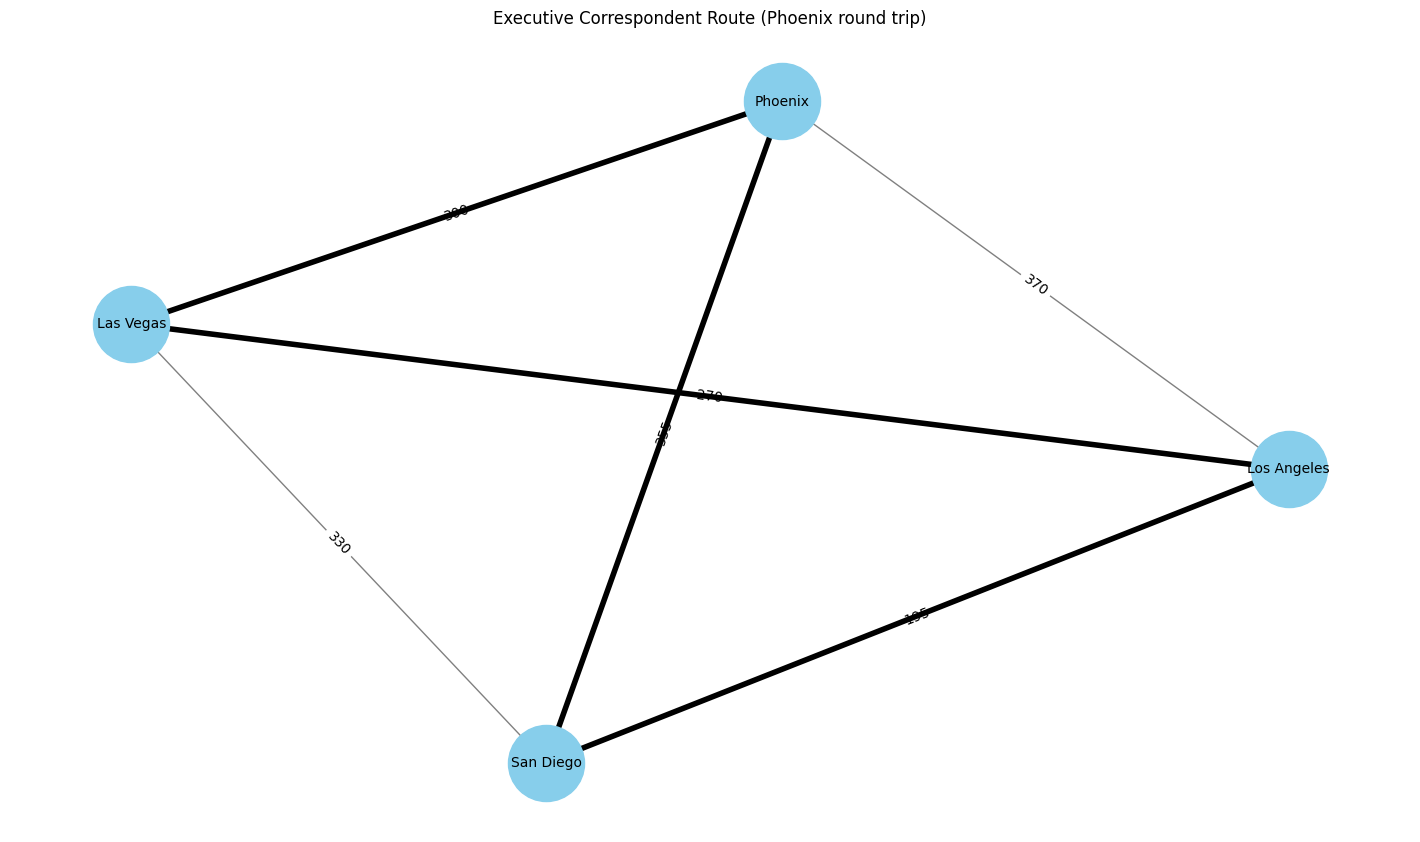

In [311]:
table = None # Resets table to not display it for executive_correspondent
employee_type = get_employee_type()

if employee_type == "2":
    table = run_city_reporter(valid_reporter_cities)
elif employee_type == "1":
    run_executive_correspondent(valid_executive_cities)

table # Will display only for City Reporter